In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from collections.abc import Iterable

## Get dataset from sklearn module and divide it into data and target


In [2]:
iris = load_iris()
X = iris.data
y = iris.target
df = pd.DataFrame(X, columns=iris.feature_names)
df["Class"] = y


### Get general description about dataset

In [4]:
df.describe()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

# Actual tree classifier using gini impurity

In [53]:
class Node:
    def __init__(self, model_class):
        self.model_class = model_class
        self.feature_index = 0
        self.threshold = 0
        self.samples = 0
        self.left = None
        self.right = None

In [55]:
class MyDecisionTreeClassifier:
    def __init__(self, max_depth: int):
        self.max_depth = max_depth

    def describe(self):
        def _describe(node, depth=0):
            if node.left:
                print(depth, 'left', [node.model_class, node.samples,
                                      node.feature_index, node.threshold])
                _describe(node.left, depth+1)
            if node.right:
                print(depth, 'right', [node.model_class, node.samples,
                                       node.feature_index, node.threshold])
                _describe(node.right, depth+1)

        node = self.tree
        print(0, 'root', [node.model_class, node.samples,
              node.feature_index, node.threshold])
        _describe(node, 1)

    def gini(self, sample_distr: list, num_samples: int):
        '''
        A Gini score gives an idea of how good a split is by how mixed the
        classes are in the two groups created by the split.
        '''
        gini = 1 - sum((n / num_samples)**2 for n in sample_distr)
        return gini

    def split_data(self, X, y) -> tuple[int, int]:
        # test all the possible splits in O(N*F) where N in number of samples
        # and F is number of features
        # return index and threshold value
        node_num_samples = y.size
        # if samples are all of one class
        if len(np.unique(y)) <= 1:
            return None, None
        samples_dstr_parent = [np.sum(y == c) for c in range(self.num_classes)]
        best_gini = self.gini(samples_dstr_parent, node_num_samples)
        best_feature, best_threshold = None, None
        # for each feature we will try every considerable threshold
        for feature_idx in range(self.num_features):
            thresholds, classes = zip(*sorted(zip(X[:, feature_idx], y)))
            left_samples_dstr = [0]*self.num_classes
            right_samples_dstr = samples_dstr_parent.copy()
            for i in range(1, node_num_samples):
                c = classes[i-1]
                left_samples_dstr[c] += 1
                right_samples_dstr[c] -= 1
                gini_left = self.gini(left_samples_dstr, i)
                gini_right = self.gini(
                    right_samples_dstr, node_num_samples - i)
                gini_child = (i * gini_left + (node_num_samples - i)
                              * gini_right) / node_num_samples
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini_child < best_gini:
                    best_gini = gini_child
                    best_feature = feature_idx
                    best_threshold = (thresholds[i] + thresholds[i - 1]) / 2
        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        # recursively split until max depth is not exeeced
        samples_dstr = [np.sum(y == i) for i in range(self.num_classes)]
        model_class = np.argmax(samples_dstr)
        # create a root node
        node = Node(model_class)
        if depth < self.max_depth:
            feature_idx, threshold = self.split_data(X, y)
            if feature_idx:
                left_tree_mask = X[:, feature_idx] < threshold
                X_left, y_left = X[left_tree_mask], y[left_tree_mask]
                X_right, y_right = X[~left_tree_mask], y[~left_tree_mask]
                node.samples = len(y)
                node.feature_index = feature_idx
                node.threshold = threshold
                node.left = self.build_tree(X_left, y_left, depth + 1)
                node.right = self.build_tree(X_right, y_right, depth + 1)
        return node

    def fit(self, X, y):
        # basically wrapper for build tree
        self.num_classes = len(set(y))
        self.num_features = X.shape[1]
        self.tree = self.build_tree(X, y)

    def _predict(self, X_test):
        # get predicted class from leaf
        node = self.tree
        while node.left:
            if X_test[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.model_class

    def predict(self, X_test):
        # traverse the tree while there is left node
        # and return the predicted class for it,
        # note that X_test can be not only one example
        node = self.tree
        if isinstance(X_test[0], Iterable):
            models = []
            for test in X_test:
                models.append(self._predict(test))
            return models
        else:
            return self._predict(X_test)


## Creating and training our model

In [63]:
from sklearn.model_selection import train_test_split
X = iris.data
y = iris.target
ctree = MyDecisionTreeClassifier(8)
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.2)
ctree.fit(X,y)

## Testing our model

In [64]:
from sklearn.metrics import mean_squared_error
models = ctree.predict(X_test)
print(mean_squared_error(y_test,models))
print(sum(models == y_test) / len(y_test))
ctree.describe()


0.03333333333333333
0.9666666666666667
0 root [0, 120, 2, 2.5999999999999996]
1 left [0, 120, 2, 2.5999999999999996]
1 right [0, 120, 2, 2.5999999999999996]
2 left [2, 76, 3, 1.65]
3 left [1, 39, 2, 5.0]
3 right [1, 39, 2, 5.0]
2 right [2, 76, 3, 1.65]
3 left [2, 37, 2, 4.85]
4 left [2, 4, 1, 3.1]
4 right [2, 4, 1, 3.1]
3 right [2, 37, 2, 4.85]


## Some interesting observations about correlation between features and classes

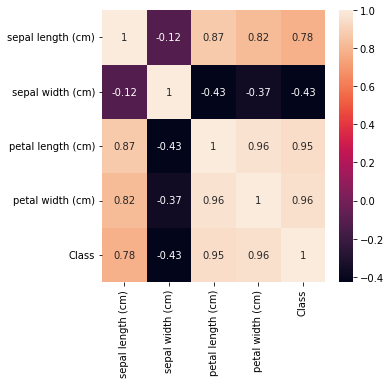

In [7]:
import seaborn as sns
plt.figure(figsize=(5,5))
cor = df.corr()
sns.heatmap(cor,annot = True)
plt.show()

## Another slightly better dataset
Also breast_cancer dataset is interesting in terms of number of samples

In [182]:
from sklearn.datasets import load_wine
wine = load_wine()
X = wine.data
y = wine.target
df = pd.DataFrame(X, columns=wine.feature_names)
df["Class"] = y

In [183]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.2)
ctree.fit(X,y)

In [184]:
models = ctree.predict(X_test)
print(mean_squared_error(y_test,models))
sum(models == y_test) / len(y_test)

0.027777777777777776


0.9722222222222222

### There are also possible some techniques like:
- entropy count(not big difference with gini)
- tree pruning and pre-pruning(kinda useless for our initial dataset which can perform well with 2 nodes)
- just get a bigger size of more diversified dataset to get better understanding about performance